In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize, rotate
import os
from os.path import join
from tensorflow import keras
from keras.applications.resnet50 import ResNet50
from keras.layers import Dense, GlobalAveragePooling2D, Input
from keras.models import Model
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import albumentations as A
#from tensorflow_addons.optimizers import AdamP

In [2]:
"""AdamP for TensorFlow."""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.python.framework import ops
from tensorflow.python.keras import backend_config
from tensorflow.python.keras.optimizer_v2 import optimizer_v2
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import control_flow_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import state_ops


class AdamP(optimizer_v2.OptimizerV2):
    _HAS_AGGREGATE_GRAD = True

    def __init__(self,
                 learning_rate=0.001,
                 beta_1=0.9,
                 beta_2=0.999,
                 epsilon=1e-8,
                 weight_decay=0.0,
                 delta=0.1, wd_ratio=0.1, nesterov=False,
                 name='AdamP',
                 **kwargs):

        super(AdamP, self).__init__(name, **kwargs)
        self._set_hyper('learning_rate', kwargs.get('lr', learning_rate))
        self._set_hyper('beta_1', beta_1)
        self._set_hyper('beta_2', beta_2)
        self._set_hyper('delta', delta)
        self._set_hyper('wd_ratio', wd_ratio)

        self.epsilon = epsilon or backend_config.epsilon()
        self.weight_decay = weight_decay
        self.nesterov = nesterov

    def _create_slots(self, var_list):
        # Create slots for the first and second moments.
        # Separate for-loops to respect the ordering of slot variables from v1.
        for var in var_list:
            self.add_slot(var, 'm')
        for var in var_list:
            self.add_slot(var, 'v')
        for var in var_list:
            self.add_slot(var, 'p')

    def _prepare_local(self, var_device, var_dtype, apply_state):
        super(AdamP, self)._prepare_local(var_device, var_dtype, apply_state)

        local_step = math_ops.cast(self.iterations + 1, var_dtype)
        beta_1_t = array_ops.identity(self._get_hyper('beta_1', var_dtype))
        beta_2_t = array_ops.identity(self._get_hyper('beta_2', var_dtype))
        beta_1_power = math_ops.pow(beta_1_t, local_step)
        beta_2_power = math_ops.pow(beta_2_t, local_step)

        lr = apply_state[(var_device, var_dtype)]['lr_t']
        bias_correction1 = 1 - beta_1_power
        bias_correction2 = 1 - beta_2_power

        delta = array_ops.identity(self._get_hyper('delta', var_dtype))
        wd_ratio = array_ops.identity(self._get_hyper('wd_ratio', var_dtype))

        apply_state[(var_device, var_dtype)].update(
            dict(
                lr=lr,
                epsilon=ops.convert_to_tensor_v2(self.epsilon, var_dtype),
                weight_decay=ops.convert_to_tensor_v2(self.weight_decay, var_dtype),
                beta_1_t=beta_1_t,
                beta_1_power=beta_1_power,
                one_minus_beta_1_t=1 - beta_1_t,
                beta_2_t=beta_2_t,
                beta_2_power=beta_2_power,
                one_minus_beta_2_t=1 - beta_2_t,
                bias_correction1=bias_correction1,
                bias_correction2=bias_correction2,
                delta=delta,
                wd_ratio=wd_ratio))

    def set_weights(self, weights):
        params = self.weights
        # If the weights are generated by Keras V1 optimizer, it includes vhats
        # optimizer has 2x + 1 variables. Filter vhats out for compatibility.
        num_vars = int((len(params) - 1) / 2)
        if len(weights) == 3 * num_vars + 1:
            weights = weights[:len(params)]
        super(AdamP, self).set_weights(weights)

    def _resource_apply_dense(self, grad, var, apply_state=None):
        var_device, var_dtype = var.device, var.dtype.base_dtype
        coefficients = ((apply_state or {}).get((var_device, var_dtype))
                        or self._fallback_apply_state(var_device, var_dtype))

        # m_t = beta1 * m + (1 - beta1) * g_t
        m = self.get_slot(var, 'm')
        m_scaled_g_values = grad * coefficients['one_minus_beta_1_t']
        m_t = state_ops.assign(m, m * coefficients['beta_1_t'] + m_scaled_g_values, use_locking=self._use_locking)

        # v_t = beta2 * v + (1 - beta2) * (g_t * g_t)
        v = self.get_slot(var, 'v')
        v_scaled_g_values = (grad * grad) * coefficients['one_minus_beta_2_t']
        v_t = state_ops.assign(v, v * coefficients['beta_2_t'] + v_scaled_g_values, use_locking=self._use_locking)

        denorm = (math_ops.sqrt(v_t) / math_ops.sqrt(coefficients['bias_correction2'])) + coefficients['epsilon']
        step_size = coefficients['lr'] / coefficients['bias_correction1']

        if self.nesterov:
            perturb = (coefficients['beta_1_t'] * m_t + coefficients['one_minus_beta_1_t'] * grad) / denorm
        else:
            perturb = m_t / denorm

        # Projection
        wd_ratio = 1
        if len(var.shape) > 1:
            perturb, wd_ratio = self._projection(var, grad, perturb, coefficients['delta'], coefficients['wd_ratio'], coefficients['epsilon'])

        # Weight decay

        if self.weight_decay > 0:
            var = state_ops.assign(var, var * (1 - coefficients['lr'] * coefficients['weight_decay'] * wd_ratio), use_locking=self._use_locking)

        var_update = state_ops.assign_sub(var, step_size * perturb, use_locking=self._use_locking)

        return control_flow_ops.group(*[var_update, m_t, v_t])


    def _resource_apply_sparse(self, grad, var, indices, apply_state=None):

        var_device, var_dtype = var.device, var.dtype.base_dtype
        coefficients = ((apply_state or {}).get((var_device, var_dtype))
                        or self._fallback_apply_state(var_device, var_dtype))
        """
        Adam
        """
        # m_t = beta1 * m + (1 - beta1) * g_t
        m = self.get_slot(var, 'm')
        m_scaled_g_values = grad * coefficients['one_minus_beta_1_t']
        m_t = state_ops.assign(m, m * coefficients['beta_1_t'],
                               use_locking=self._use_locking)
        with ops.control_dependencies([m_t]):
            m_t = self._resource_scatter_add(m, indices, m_scaled_g_values)

        # v_t = beta2 * v + (1 - beta2) * (g_t * g_t)
        v = self.get_slot(var, 'v')
        v_scaled_g_values = (grad * grad) * coefficients['one_minus_beta_2_t']
        v_t = state_ops.assign(v, v * coefficients['beta_2_t'],
                               use_locking=self._use_locking)
        with ops.control_dependencies([v_t]):
            v_t = self._resource_scatter_add(v, indices, v_scaled_g_values)

        denorm = (math_ops.sqrt(v_t) / math_ops.sqrt(coefficients['bias_correction2'])) + coefficients['epsilon']
        step_size = coefficients['lr'] / coefficients['bias_correction1']

        if self.nesterov:
            p_scaled_g_values = grad * coefficients['one_minus_beta_1_t']
            perturb = m_t * coefficients['beta_1_t']
            perturb = self._resource_scatter_add(perturb, indices, p_scaled_g_values) / denorm

        else:
            perturb = m_t / denorm

        # Projection
        wd_ratio = 1
        if len(var.shape) > 1:
            perturb, wd_ratio = self._projection(var, grad, perturb, coefficients['delta'], coefficients['wd_ratio'], coefficients['epsilon'])

        # Weight decay
        if self.weight_decay > 0:
            var = state_ops.assign(var, var * (1 - coefficients['lr'] * coefficients['weight_decay'] * wd_ratio), use_locking=self._use_locking)

        var_update = state_ops.assign_sub(var, step_size * perturb, use_locking=self._use_locking)

        return control_flow_ops.group(*[var_update, m_t, v_t])

    def _channel_view(self, x):
        return array_ops.reshape(x, shape=[x.shape[0], -1])

    def _layer_view(self, x):
        return array_ops.reshape(x, shape=[1, -1])

    def _cosine_similarity(self, x, y, eps, view_func):
        x = view_func(x)
        y = view_func(y)

        x_norm = math_ops.euclidean_norm(x, axis=-1) + eps
        y_norm = math_ops.euclidean_norm(y, axis=-1) + eps
        dot = math_ops.reduce_sum(x * y, axis=-1)

        return math_ops.abs(dot) / x_norm / y_norm

    def _projection(self, var, grad, perturb, delta, wd_ratio, eps):
        # channel_view
        cosine_sim = self._cosine_similarity(grad, var, eps, self._channel_view)
        cosine_max = math_ops.reduce_max(cosine_sim)
        compare_val = delta / math_ops.sqrt(math_ops.cast(self._channel_view(var).shape[-1], dtype=delta.dtype))

        perturb, wd = control_flow_ops.cond(pred=cosine_max < compare_val,
                                            true_fn=lambda : self.channel_true_fn(var, perturb, wd_ratio, eps),
                                            false_fn=lambda : self.channel_false_fn(var, grad, perturb, delta, wd_ratio, eps))

        return perturb, wd

    def channel_true_fn(self, var, perturb, wd_ratio, eps):
        expand_size = [-1] + [1] * (len(var.shape) - 1)
        var_n = var / (array_ops.reshape(math_ops.euclidean_norm(self._channel_view(var), axis=-1), shape=expand_size) + eps)
        perturb -= var_n * array_ops.reshape(math_ops.reduce_sum(self._channel_view(var_n * perturb), axis=-1), shape=expand_size)
        wd = wd_ratio

        return perturb, wd

    def channel_false_fn(self, var, grad, perturb, delta, wd_ratio, eps):
        cosine_sim = self._cosine_similarity(grad, var, eps, self._layer_view)
        cosine_max = math_ops.reduce_max(cosine_sim)
        compare_val = delta / math_ops.sqrt(math_ops.cast(self._layer_view(var).shape[-1], dtype=delta.dtype))

        perturb, wd = control_flow_ops.cond(cosine_max < compare_val,
                                              true_fn=lambda : self.layer_true_fn(var, perturb, wd_ratio, eps),
                                              false_fn=lambda : self.identity_fn(perturb))

        return perturb, wd

    def layer_true_fn(self, var, perturb, wd_ratio, eps):
        expand_size = [-1] + [1] * (len(var.shape) - 1)
        var_n = var / (array_ops.reshape(math_ops.euclidean_norm(self._layer_view(var), axis=-1), shape=expand_size) + eps)
        perturb -= var_n * array_ops.reshape(math_ops.reduce_sum(self._layer_view(var_n * perturb), axis=-1), shape=expand_size)
        wd = wd_ratio

        return perturb, wd

    def identity_fn(self, perturb):
        wd = 1.0

        return perturb, wd

    def get_config(self):
        config = super(AdamP, self).get_config()
        config.update({
            'learning_rate': self._serialize_hyperparameter('learning_rate'),
            'beta_1': self._serialize_hyperparameter('beta_1'),
            'beta_2': self._serialize_hyperparameter('beta_2'),
            'delta': self._serialize_hyperparameter('delta'),
            'wd_ratio': self._serialize_hyperparameter('wd_ratio'),
            'epsilon': self.epsilon,
            'weight_decay': self.weight_decay,
            'nesterov': self.nesterov
        })
        return config

In [3]:
data_path = 'public_tests/00_test_img_input/train/images/'
gt_path = 'public_tests/00_test_img_input/train/gt.csv'

test_path = 'public_tests/hyperdataset/miha/images/'
test_gt = 'public_tests/hyperdataset/miha/gt.csv'

In [4]:
gt = pd.read_csv(gt_path)
gt

,filename,class_id
0,0000.jpg,0
1,0001.jpg,0
2,0002.jpg,0
3,0003.jpg,0
4,0004.jpg,0
...,...,...
2495,2495.jpg,49
2496,2496.jpg,49
2497,2497.jpg,49
2498,2498.jpg,49


In [5]:
def read_and_resize_data(data_path, gt_path):
    gt = pd.read_csv(gt_path)
    gt_dict = {}
    for i, row in gt.iterrows():
        gt_dict[row['filename']] = row['class_id']
    files = sorted(os.listdir(data_path))
    x, y = [], []
    for file in tqdm(files, desc='reading data...'):
        im = imread(data_path + '/' + file)
        
        img = resize(im, (224, 224, 3))
        class_ = np.zeros(50)
        class_[gt_dict[file]] = 1.
        x.append(img)
        y.append(class_)
    return (np.array(x)).astype('float32') , np.array(y).astype('float32')

In [6]:
X_train, y_train = read_and_resize_data(data_path, gt_path)

In [7]:
X_test, y_test = read_and_resize_data(test_path, test_gt)

In [8]:
#X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1)

In [9]:
X_train.shape, X_test.shape

((2500, 224, 224, 3), (500, 224, 224, 3))

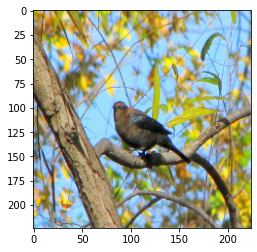

In [10]:
plt.imshow(X_train[243])

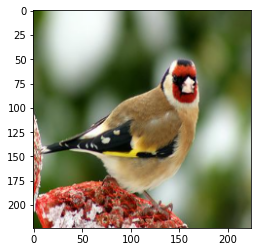

In [11]:
plt.imshow(X_test[243])

In [12]:
def mirror(img):
    new_img = np.zeros((224, 224, 3))
    new_img[:, :, 0] = np.fliplr(img[:, :, 0])
    new_img[:, :, 1] = np.fliplr(img[:, :, 1])
    new_img[:, :, 2] = np.fliplr(img[:, :, 2])
    
    return new_img

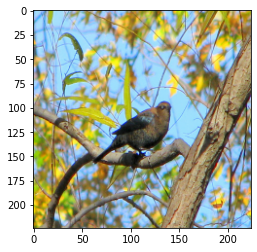

In [13]:
plt.imshow(mirror(X_train[243]))

In [14]:
def rotation(image, ang_pos):
    a=ang_pos*np.pi/180
    img=rotate(image,ang_pos,center=(0,0),mode='constant',resize=False,order=1)

    return img

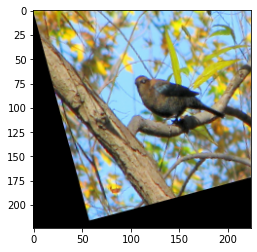

In [15]:
plt.imshow(rotation(X_train[243], 15))

In [16]:
def generator(x_train, y_train, batch_size=64):
    cur = 0
    indices = np.arange(x_train.shape[0])
    np.random.shuffle(indices)
    x_train = x_train[indices]
    y_train = y_train[indices]
    while True:
        batchx = np.zeros((batch_size, 224, 224, 3))
        batchy = np.zeros((batch_size, 50))
        for i in range(batch_size):
            m = (np.random.rand() > 0.5)
            if m:
                batchx[i], batchy[i] = mirror(x_train[cur]), y_train[cur]
            else:
                batchx[i], batchy[i] = x_train[cur], y_train[cur]
            ang = np.random.rand() * 20 - 10
            batchx[i], batchy[i] = rotation(batchx[i], ang), batchy[i]
            cur += 1
            if cur == x_train.shape[0]:
                batchx = batchx[:i+1, :]
                batchy = batchy[:i+1, :]
                indices = np.arange(x_train.shape[0])
                np.random.shuffle(indices)
                x_train = x_train[indices]
                y_train = y_train[indices]
                cur = 0
                break
        yield batchx.astype('float32'), batchy.astype('float32')

In [17]:
def generator(x_train, y_train, batch_size=64):
    cur = 0
    indices = np.arange(x_train.shape[0])
    np.random.shuffle(indices)
    x_train = x_train[indices]
    y_train = y_train[indices]
    while True:
        batchx = np.zeros((batch_size, 224, 224, 3))
        batchy = np.zeros((batch_size, 50))
        for i in range(batch_size):
            transform = A.Compose([
                    A.Flip(),
                    A.RandomRotate90(),
                    A.Transpose(),
                    A.OneOf([
                        A.RandomRain(),
                        A.RandomFog(),
                        #A.RandomSunFlare()
                    ], p=0.2),
                    A.JpegCompression(),
                    A.GaussNoise(var_limit=(0.001, 0.01)),
                    A.Blur(blur_limit=1.5, p=0.1),
                    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=40, p=0.8),
                    A.OneOf([
                        A.OpticalDistortion(p=0.3),
                        A.GridDistortion(p=.1),
                        A.IAAPiecewiseAffine(p=0.3),
                    ], p=0.2),
                    A.RandomBrightnessContrast(),            
                ])
            batchx[i] = np.array(transform(image=x_train[cur])['image'])
            batchy[i] = y_train[cur]
            cur += 1
            if cur == x_train.shape[0]:
                batchx = batchx[:i+1, :]
                batchy = batchy[:i+1, :]
                indices = np.arange(x_train.shape[0])
                np.random.shuffle(indices)
                x_train = x_train[indices]
                y_train = y_train[indices]
                cur = 0
                break
        yield batchx.astype('float32'), batchy.astype('float32')

/home/azelentsov/.local/lib/python3.8/site-packages/albumentations/augmentations/functional.py:788: UserWarning: Image compression augmentation is most effective with uint8 inputs, float32 is used as input.
  warn(


1.0 0.095517434


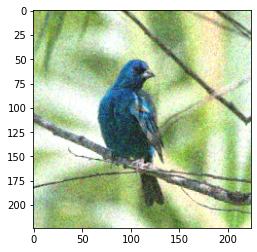

In [18]:
for x, y in generator(X_train, y_train):
    plt.imshow(x[0])
    print(np.max(x[0]), np.min(x[0]))
    break

# Optimizer

# Model

In [19]:
model = keras.models.load_model('1.h5')
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
_______________________________________________________________________________________

In [20]:
NUM_CLASSES = 50
base_model = keras.applications.Xception
base_model = base_model(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
lay = base_model.get_layer("block14_sepconv2_act").output
#lay =  keras.layers.Conv2D(1024, (1, 1), padding='same', activation='relu', kernel_regularizer='l2')(lay)
#lay =  keras.layers.Conv2D(512, (1, 1), padding='same', activation='relu', kernel_regularizer='l2')(lay)
lay = keras.layers.GlobalAveragePooling2D()(lay)
#lay = keras.layers.Flatten()(lay)
lay = keras.layers.Dense(1024, activation='elu')(lay)
lay = keras.layers.Dropout(0.3)(lay)
lay = keras.layers.Dense(1024, activation='elu')(lay)
lay = keras.layers.Dropout(0.4)(lay)
predictions = keras.layers.Dense(NUM_CLASSES, activation='softmax')(lay)
model = Model(inputs=base_model.input, outputs=predictions)
print(len(model.layers))
first_trainable = 116
for i in range(first_trainable):
    model.layers[i].trainable = False
    if model.layers[i].name.startswith('add'):
        print(i)
for i in range(first_trainable, len(model.layers)):
    model.layers[i].trainable = True
    #model.layers[i].kernel_regularizer = 'l2'
    
model.summary()

138
15
25
35
45
55
65
75
85
95
105
115
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
________________________________________________

In [21]:
def focal_loss(y_true, y_pred, gamma=1):
    return -keras.backend.sum((y_true * keras.backend.pow((1 - y_pred), gamma) *
                              keras.backend.log(y_pred + 0.00000001)), axis=1)

In [22]:
opt = AdamP(learning_rate=0.001, beta_1=0.9, beta_2=0.999, weight_decay=1e-5)
multipliers = {}
#for i in range(132):
#    if base_model.layers[i].name.startswith('block') and int(base_model.layers[i].name[5]) > 10:
#        multipliers[base_model.layers[i].name] = (1 - (14 - int(base_model.layers[i].name[5])) / 14)
#print(multipliers)
#opt = LearningRateMultiplier(keras.optimizers.Adam, lr_multiplier=multipliers, lr=0.001, momentum=0.9)
model.compile(opt, loss=focal_loss, metrics=['accuracy'])
reducelr = keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 20, verbose = 1)

In [23]:
#X_train = (X_train - np.mean(X_train)) / np.std(X_train)
#X_test = (X_test - np.mean(X_test)) / np.std(X_test)
print(np.mean(X_train), np.std(X_train), np.mean(X_test), np.std(X_test))

0.48699784 0.24395855 0.48571122 0.24298285


In [29]:
h = model.fit_generator(generator(X_train, y_train, 64),
                        validation_data=(X_test, y_test),
                        steps_per_epoch=X_train.shape[0]//64, epochs=300,
                        callbacks=[reducelr])# validation_batch_size=64)

Epoch 1/300
39/39 [==============================] - 16s 409ms/step - loss: 0.2125 - accuracy: 0.9083 - val_loss: 0.1576 - val_accuracy: 0.9240
Epoch 2/300
39/39 [==============================] - 16s 398ms/step - loss: 0.1620 - accuracy: 0.9298 - val_loss: 0.2046 - val_accuracy: 0.9040
Epoch 3/300
39/39 [==============================] - 15s 395ms/step - loss: 0.1231 - accuracy: 0.9516 - val_loss: 0.2032 - val_accuracy: 0.9080
Epoch 4/300
39/39 [==============================] - 15s 392ms/step - loss: 0.1541 - accuracy: 0.9298 - val_loss: 0.2779 - val_accuracy: 0.8660
Epoch 5/300
39/39 [==============================] - 15s 394ms/step - loss: 0.1242 - accuracy: 0.9466 - val_loss: 0.2684 - val_accuracy: 0.8880
Epoch 6/300
39/39 [==============================] - 16s 407ms/step - loss: 0.1409 - accuracy: 0.9360 - val_loss: 0.3016 - val_accuracy: 0.8640
Epoch 7/300
39/39 [==============================] - 16s 408ms/step - loss: 0.1638 - accuracy: 0.9314 - val_loss: 0.3151 - val_accuracy:

KeyboardInterrupt: 

In [30]:
model.save('model_ch.hdf5')

In [87]:
model.save('birds_model.hdf5')

In [95]:
model.save('birds_model1.hdf5')

# Evaluation

In [33]:
NUM_CLASSES = 50
base_model = keras.applications.Xception
base_model = base_model(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
lay = base_model.get_layer("block14_sepconv2_act").output
#lay =  keras.layers.Conv2D(1024, (1, 1), padding='same', activation='relu', kernel_regularizer='l2')(lay)
#lay =  keras.layers.Conv2D(512, (1, 1), padding='same', activation='relu', kernel_regularizer='l2')(lay)
lay = keras.layers.GlobalAveragePooling2D()(lay)
#lay = keras.layers.Flatten()(lay)
lay = keras.layers.Dense(1024, activation='elu')(lay)
lay = keras.layers.Dropout(0.3)(lay)
lay = keras.layers.Dense(1024, activation='elu')(lay)
lay = keras.layers.Dropout(0.4)(lay)
predictions = keras.layers.Dense(NUM_CLASSES, activation='softmax')(lay)
model = Model(inputs=base_model.input, outputs=predictions)
print(len(model.layers))
first_trainable = 116
for i in range(first_trainable):
    model.layers[i].trainable = False
    if model.layers[i].name.startswith('add'):
        print(i)
for i in range(first_trainable, len(model.layers)):
    model.layers[i].trainable = True
    #model.layers[i].kernel_regularizer = 'l2'
    
model.summary()
model.load_weights('model_ch.hdf5')
model.summary()
model.compile('adam', 'categorical_crossentropy', metrics='accuracy')

138
15
25
35
45
55
65
75
85
95
105
115
Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
________________________________________________

block3_sepconv2_bn (BatchNormal (None, 55, 55, 256)  1024        block3_sepconv2[0][0]            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 28, 28, 256)  32768       add_24[0][0]                     
__________________________________________________________________________________________________
block3_pool (MaxPooling2D)      (None, 28, 28, 256)  0           block3_sepconv2_bn[0][0]         
__________________________________________________________________________________________________
batch_normalization_9 (BatchNor (None, 28, 28, 256)  1024        conv2d_9[0][0]                   
__________________________________________________________________________________________________
add_25 (Add)                    (None, 28, 28, 256)  0           block3_pool[0][0]                
                                                                 batch_normalization_9[0][0]      
__________

In [37]:
model = keras.models.load_model('birds_model.hdf5')

In [38]:
y_pred = model.predict(X_test)
p = 0
for i in range(y_pred.shape[0]):
    if np.argmax(y_pred[i]) == np.argmax(y_test[i]):
        p += 1
p / 500

0.852

In [39]:
y_pred = model.predict(X_train)
p = 0
for i in range(y_pred.shape[0]):
    if np.argmax(y_pred[i]) == np.argmax(y_train[i]):
        p += 1
p / 2500

0.9984

In [36]:
model.save('birds_model.hdf5')